In [1]:
# Imports
import random
import time
import matplotlib.pyplot as plt


## Board and Helper Functions


In [2]:
def new_board():
    """Create an empty Tic-Tac-Toe board (9 cells)."""
    return [' '] * 9

def print_board(board):
    """Print the board in a 3x3 layout."""
    print()
    print(f" {board[0]} | {board[1]} | {board[2]} ")
    print("---|---|---")
    print(f" {board[3]} | {board[4]} | {board[5]} ")
    print("---|---|---")
    print(f" {board[6]} | {board[7]} | {board[8]} ")
    print()

def print_positions():
    """Show index positions for a beginner-friendly UI."""
    print("Positions:")
    print(" 0 | 1 | 2 ")
    print("---|---|---")
    print(" 3 | 4 | 5 ")
    print("---|---|---")
    print(" 6 | 7 | 8 ")
    print()

def available_moves(board):
    """Return indexes of empty cells."""
    return [i for i in range(9) if board[i] == ' ']

def other_player(player):
    """Switch player: X -> O, O -> X"""
    return 'O' if player == 'X' else 'X'

def board_full(board):
    """True if board has no empty spaces."""
    return ' ' not in board

def winner(board, player):
    """Check if a player has won."""
    win_lines = [
        (0,1,2),(3,4,5),(6,7,8),
        (0,3,6),(1,4,7),(2,5,8),
        (0,4,8),(2,4,6)
    ]
    for a,b,c in win_lines:
        if board[a] == board[b] == board[c] == player:
            return True
    return False


## 1) Minimax (Perfect AI)


In [3]:
# Minimax
def minimax(board, player):
    """
    Minimax returns:
      - index: best move index
      - score: score from X perspective (+1 win X, -1 win O, 0 draw)
    """
    opponent = other_player(player)

    # Terminal states
    if winner(board, 'X'):
        return {'index': None, 'score': 1}

    if winner(board, 'O'):
        return {'index': None, 'score': -1}

    if board_full(board):
        return {'index': None, 'score': 0}

    # Try all possible moves
    results = []
    for move in available_moves(board):
        board[move] = player
        outcome = minimax(board, opponent)
        results.append({'index': move, 'score': outcome['score']})
        board[move] = ' '  # undo move

    # Choose best move depending on player
    if player == 'X':
        best_move = max(results, key=lambda x: x['score'])
    else:
        best_move = min(results, key=lambda x: x['score'])

    return best_move



## 2) Depth-Limited Minimax + Heuristic


In [4]:
def heuristic(board, root_player):
    """
    heuristic:
    +10 if root_player has 2 in a line and 1 empty
    -10 if opponent has 2 in a line and 1 empty
    + small bonus for center and corners
    """
    opp = other_player(root_player)
    score = 0

    lines = [
        (0,1,2),(3,4,5),(6,7,8),
        (0,3,6),(1,4,7),(2,5,8),
        (0,4,8),(2,4,6)
    ]

    for a,b,c in lines:
        line = [board[a], board[b], board[c]]
        root_count = line.count(root_player)
        opp_count = line.count(opp)
        empty_count = line.count(' ')

        if root_count == 2 and empty_count == 1:
            score += 10
        if opp_count == 2 and empty_count == 1:
            score -= 10

    # Prefer center
    if board[4] == root_player:
        score += 2
    elif board[4] == opp:
        score -= 2

    # Prefer corners
    for corner in [0,2,6,8]:
        if board[corner] == root_player:
            score += 1
        elif board[corner] == opp:
            score -= 1

    return score


def depth_limited_minimax(board, current_player, root_player, depth=0, max_depth=2):
    """
    Depth-limited minimax:
    - Stops at max_depth and uses heuristic
    - Uses big scores for real wins/losses
    - Scores are from root_player perspective
    """
    root_opp = other_player(root_player)
    opp = other_player(current_player)

    # Terminal
    if winner(board, root_player):
        return {'index': None, 'score': 100 - depth}
    if winner(board, root_opp):
        return {'index': None, 'score': depth - 100}
    if board_full(board):
        return {'index': None, 'score': 0}

    # Cutoff
    if depth >= max_depth:
        return {'index': None, 'score': heuristic(board, root_player)}

    # Try moves
    results = []
    for move in available_moves(board):
        board[move] = current_player
        outcome = depth_limited_minimax(board, opp, root_player, depth+1, max_depth)
        results.append({'index': move, 'score': outcome['score']})
        board[move] = ' '

    # Max if root's turn, else Min
    if current_player == root_player:
        return max(results, key=lambda x: x['score'])
    else:
        return min(results, key=lambda x: x['score'])


## 3) Rule-Based AI


In [5]:
def rule_based_ai(board, player):
    """Win now, block now, else random."""
    opp = other_player(player)
    moves = available_moves(board)

    # 1) win now
    for move in moves:
        board[move] = player
        if winner(board, player):
            board[move] = ' '
            return move
        board[move] = ' '

    # 2) block opponent win
    for move in moves:
        board[move] = opp
        if winner(board, opp):
            board[move] = ' '
            return move
        board[move] = ' '

    # 3) random move
    return random.choice(moves)


# Play vs AI (Interactive)

In [6]:
def ai_move(board, player, ai_name, depth_limit=2):
    """Return (move, time_taken_seconds)."""
    start = time.time()

    if ai_name == 'minimax':
        move = minimax(board, player)['index']
    elif ai_name == 'heuristic':
        move = depth_limited_minimax(board, player, root_player=player, max_depth=depth_limit)['index']
    elif ai_name == 'rule':
        move = rule_based_ai(board, player)
    else:
        move = random.choice(available_moves(board))

    dt = time.time() - start
    return move, dt


def play_human_vs_ai(ai_name='minimax', depth_limit=2):
    board = new_board()
    human = 'O'
    ai = 'X'
    current = 'X'

    print("You are O. AI is X.")
    print_positions()
    print_board(board)

    while True:
        if current == human:
            move_str = input("Enter your move (0-8): ").strip()
            if not move_str.isdigit():
                print("Please type a number 0-8.")
                continue
            move = int(move_str)
            if move not in available_moves(board):
                print("Invalid move. Try again.")
                continue
            board[move] = human
        else:
            move, dt = ai_move(board, ai, ai_name, depth_limit=depth_limit)
            board[move] = ai
            print(f"AI ({ai_name}) chose {move} in {dt*1000:.2f} ms")

        print_board(board)

        if winner(board, current):
            print("Winner:", current)
            return
        if board_full(board):
            print("Draw!")
            return

        current = other_player(current)


## Comparative Analysis Setup


In [7]:
def x_score_to_player(score_x, player):
    """Convert minimax score (X perspective) to the current player's perspective."""
    return score_x if player == 'X' else -score_x

def optimal_move_and_score(board, player):
    """Ground-truth optimal move/score using full minimax."""
    best = minimax(board, player)
    opt_move = best['index']
    opt_score = x_score_to_player(best['score'], player)
    return opt_move, opt_score

def chosen_move_score(board, player, move):
    """Evaluate a move by assuming the opponent plays optimally after it."""
    opp = other_player(player)
    board[move] = player
    result = minimax(board, opp)
    board[move] = ' '
    return x_score_to_player(result['score'], player)


def best_possible_score(board, player):
    """
    Best possible outcome score (player perspective) from this board.
    We check every legal move, evaluate it using minimax, and take the best score.
    """
    moves = available_moves(board)
    scores = []
    for mv in moves:
        s = chosen_move_score(board, player, mv)
        scores.append(s)
    return max(scores)


In [8]:
def pick_move_for_analysis(board, player, algo_name, depth_limit=2):
    """Pick a move and measure decision time."""
    start = time.time()

    if algo_name == 'minimax':
        move = minimax(board, player)['index']
    elif algo_name == 'heuristic':
        move = depth_limited_minimax(board, player, root_player=player, max_depth=depth_limit)['index']
    elif algo_name == 'rule':
        move = rule_based_ai(board, player)
    else:
        move = random.choice(available_moves(board))

    dt = time.time() - start
    return move, dt


def create_stats():
    algos = ['minimax', 'heuristic', 'rule']
    return {
        'W': {a: 0 for a in algos},
        'L': {a: 0 for a in algos},
        'D': {a: 0 for a in algos},
        'moves': {a: 0 for a in algos},
        'time': {a: 0.0 for a in algos},
        'opt_moves': {a: 0 for a in algos},
        'eval_moves': {a: 0 for a in algos},
        'regret_sum': {a: 0.0 for a in algos},
    }


def play_ai_game(ai_X, ai_O, stats, depth_limit=2):
    """Play one game (ai_X plays X, ai_O plays O). Return 'X', 'O', or 'D'."""
    board = new_board()
    current = 'X'

    while True:
        algo = ai_X if current == 'X' else ai_O

        # Best possible score from this board (ground truth, score-based)
        best_score = best_possible_score(board, current)

        # AI move
        move, dt = pick_move_for_analysis(board, current, algo, depth_limit=depth_limit)

        # Score of the chosen move
        chosen_score = chosen_move_score(board, current, move)

        # Regret (0 means this move is as good as optimal)
        regret = best_score - chosen_score

        # Move is considered optimal if it achieves the best possible score
        is_optimal = (chosen_score == best_score)

        # Record move stats
        stats['moves'][algo] += 1
        stats['time'][algo] += dt
        stats['eval_moves'][algo] += 1
        if is_optimal:
            stats['opt_moves'][algo] += 1
        stats['regret_sum'][algo] += regret

        # Apply move
        board[move] = current

        # End checks
        if winner(board, current):
            return current
        if board_full(board):
            return 'D'

        current = other_player(current)


def run_comparative_analysis(games_per_matchup=20, depth_limit=2):
    """
    Default games_per_matchup=20 so it runs quickly.
    """
    stats = create_stats()
    matchups = [
        ('minimax', 'heuristic'),
        ('minimax', 'rule'),
        ('heuristic', 'rule')
    ]

    for a1, a2 in matchups:
        for i in range(games_per_matchup):
            # Alternate who starts as X
            if i % 2 == 0:
                ai_X, ai_O = a1, a2
            else:
                ai_X, ai_O = a2, a1

            result = play_ai_game(ai_X, ai_O, stats, depth_limit=depth_limit)

            if result == 'D':
                stats['D'][ai_X] += 1
                stats['D'][ai_O] += 1
            elif result == 'X':
                stats['W'][ai_X] += 1
                stats['L'][ai_O] += 1
            else:  # result == 'O'
                stats['W'][ai_O] += 1
                stats['L'][ai_X] += 1

    return stats


In [9]:
# Run experiments
stats = run_comparative_analysis(games_per_matchup=100, depth_limit=2)
stats


{'W': {'minimax': 53, 'heuristic': 30, 'rule': 0},
 'L': {'minimax': 0, 'heuristic': 0, 'rule': 83},
 'D': {'minimax': 147, 'heuristic': 170, 'rule': 117},
 'moves': {'minimax': 859, 'heuristic': 873, 'rule': 817},
 'time': {'minimax': 111.77787637710571,
  'heuristic': 0.13139081001281738,
  'rule': 0.010581016540527344},
 'opt_moves': {'minimax': 859, 'heuristic': 873, 'rule': 734},
 'eval_moves': {'minimax': 859, 'heuristic': 873, 'rule': 817},
 'regret_sum': {'minimax': 0.0, 'heuristic': 0.0, 'rule': 83.0}}

## Summary Table

In [10]:
def summarize(stats):
    algos = ['minimax', 'heuristic', 'rule']
    summary = {}

    for a in algos:
        total_games = stats['W'][a] + stats['L'][a] + stats['D'][a]

        no_loss_acc = (stats['W'][a] + stats['D'][a]) / total_games if total_games > 0 else 0.0
        avg_ms = (stats['time'][a] / stats['moves'][a]) * 1000 if stats['moves'][a] > 0 else 0.0
        move_acc = (stats['opt_moves'][a] / stats['eval_moves'][a]) if stats['eval_moves'][a] > 0 else 0.0
        avg_regret = (stats['regret_sum'][a] / stats['eval_moves'][a]) if stats['eval_moves'][a] > 0 else 0.0

        summary[a] = {
            'TotalGames': total_games,
            'Wins': stats['W'][a],
            'Losses': stats['L'][a],
            'Draws': stats['D'][a],
            'NoLossAcc%': no_loss_acc * 100,
            'AvgTimeMs': avg_ms,
            'MoveAcc%': move_acc * 100,
            'AvgRegret': avg_regret
        }

    return summary


def print_summary_table(summary):
    print("="*95)
    print("Algorithm Summary")
    print("="*95)
    header = f"{'Algo':<10} {'W':>4} {'L':>4} {'D':>4} {'NoLoss%':>10} {'MoveAcc%':>10} {'Regret':>10} {'Time(ms)':>10}"
    print(header)
    print("-"*95)

    for algo, s in summary.items():
        row = f"{algo:<10} {s['Wins']:>4} {s['Losses']:>4} {s['Draws']:>4} {s['NoLossAcc%']:>10.1f} {s['MoveAcc%']:>10.1f} {s['AvgRegret']:>10.3f} {s['AvgTimeMs']:>10.2f}"
        print(row)

    print("="*95)


summary = summarize(stats)
print_summary_table(summary)


Algorithm Summary
Algo          W    L    D    NoLoss%   MoveAcc%     Regret   Time(ms)
-----------------------------------------------------------------------------------------------
minimax      53    0  147      100.0      100.0      0.000     130.13
heuristic    30    0  170      100.0      100.0      0.000       0.15
rule          0   83  117       58.5       89.8      0.102       0.01


In [11]:
# Prepare values for graphs
algos = ['minimax', 'heuristic', 'rule']
x = list(range(len(algos)))

wins = [summary[a]['Wins'] for a in algos]
draws = [summary[a]['Draws'] for a in algos]
losses = [summary[a]['Losses'] for a in algos]

avg_time = [summary[a]['AvgTimeMs'] for a in algos]
move_acc = [summary[a]['MoveAcc%'] for a in algos]
avg_regret = [summary[a]['AvgRegret'] for a in algos]


## Graph 1: Win / Draw / Loss Counts

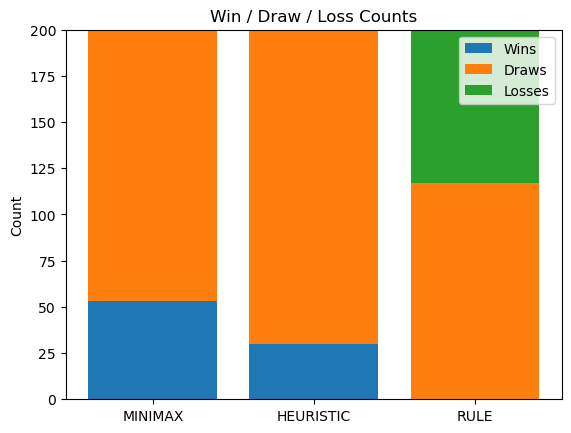

In [12]:
plt.figure()
plt.bar(x, wins, label='Wins')
plt.bar(x, draws, bottom=wins, label='Draws')
plt.bar(x, losses, bottom=[wins[i] + draws[i] for i in x], label='Losses')

plt.xticks(x, [a.upper() for a in algos])
plt.ylabel('Count')
plt.title('Win / Draw / Loss Counts')
plt.legend()
plt.show()


## Graph 2: Average Decision Time per Move

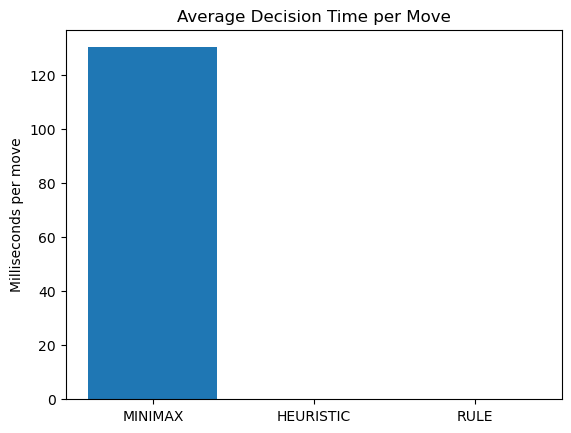

In [13]:
plt.figure()
plt.bar(x, avg_time)

plt.xticks(x, [a.upper() for a in algos])
plt.ylabel('Milliseconds per move')
plt.title('Average Decision Time per Move')
plt.show()


## Graph 3: Move Accuracy vs Optimal (Minimax)

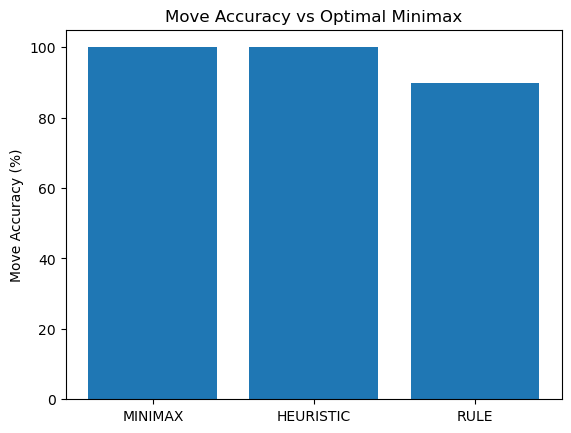

In [14]:
plt.figure()
plt.bar(x, move_acc)

plt.xticks(x, [a.upper() for a in algos])
plt.ylabel('Move Accuracy (%)')
plt.title('Move Accuracy vs Optimal Minimax')
plt.show()


## Graph 4: Average Regret per Move

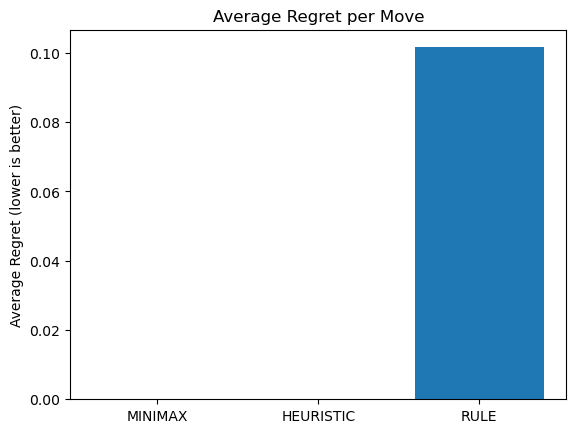

In [15]:
plt.figure()
plt.bar(x, avg_regret)

plt.xticks(x, [a.upper() for a in algos])
plt.ylabel('Average Regret (lower is better)')
plt.title('Average Regret per Move')
plt.show()


In [ ]:
def plot_wdl(summary):
    algos = ['minimax', 'heuristic', 'rule']
    x = list(range(len(algos)))

    wins = [summary[a]['Wins'] for a in algos]
    draws = [summary[a]['Draws'] for a in algos]
    losses = [summary[a]['Losses'] for a in algos]

    plt.figure()
    plt.bar(x, wins, label='Wins')
    plt.bar(x, draws, bottom=wins, label='Draws')
    plt.bar(x, losses, bottom=[wins[i] + draws[i] for i in x], label='Losses')

    plt.xticks(x, [a.upper() for a in algos])
    plt.ylabel('Count')
    plt.title('Win / Draw / Loss Counts')
    plt.legend()
    plt.show()


def plot_avg_time(summary):
    algos = ['minimax', 'heuristic', 'rule']
    x = list(range(len(algos)))
    avg_time = [summary[a]['AvgTimeMs'] for a in algos]

    plt.figure()
    plt.bar(x, avg_time)
    plt.xticks(x, [a.upper() for a in algos])
    plt.ylabel('Milliseconds per move')
    plt.title('Average Decision Time per Move')
    plt.show()


def plot_move_accuracy(summary):
    algos = ['minimax', 'heuristic', 'rule']
    x = list(range(len(algos)))
    move_acc = [summary[a]['MoveAcc%'] for a in algos]

    plt.figure()
    plt.bar(x, move_acc)
    plt.xticks(x, [a.upper() for a in algos])
    plt.ylabel('Move Accuracy (%)')
    plt.title('Move Accuracy vs Optimal Minimax')
    plt.show()


def plot_avg_regret(summary):
    algos = ['minimax', 'heuristic', 'rule']
    x = list(range(len(algos)))
    avg_regret = [summary[a]['AvgRegret'] for a in algos]

    plt.figure()
    plt.bar(x, avg_regret)
    plt.xticks(x, [a.upper() for a in algos])
    plt.ylabel('Average Regret (lower is better)')
    plt.title('Average Regret per Move')
    plt.show()


def run_and_show_analysis():
    games_per_matchup = 20   
    depth_limit = 2         

    print(f"Running comparative analysis: games_per_matchup={games_per_matchup}, depth_limit={depth_limit}")
    stats = run_comparative_analysis(games_per_matchup=games_per_matchup, depth_limit=depth_limit)

    summary = summarize(stats)
    print_summary_table(summary)

    # Show graphs
    plot_wdl(summary)
    plot_avg_time(summary)
    plot_move_accuracy(summary)
    plot_avg_regret(summary)


def main_menu():
    while True:
        print("\n" + "="*60)
        print("TIC-TAC-TOE AI - MENU")
        print("="*60)
        print("1) Play vs Minimax")
        print("2) Play vs Depth-Limited Minimax (Heuristic)")
        print("3) Play vs Rule-Based AI")
        print("4) Run Comparative Analysis (table + graphs)")
        print("5) Exit")

        choice = input("Enter choice (1-5): ").strip()

        if choice == "1":
            play_human_vs_ai('minimax')
        elif choice == "2":
            # Change depth_limit here
            play_human_vs_ai('heuristic', depth_limit=2)
        elif choice == "3":
            play_human_vs_ai('rule')
        elif choice == "4":
            run_and_show_analysis()
        elif choice == "5":
            print("Exiting menu. Done!")
            break
        else:
            print("Invalid choice. Please enter 1-5.")


# Run the menu:
main_menu()



TIC-TAC-TOE AI - MENU
1) Play vs Minimax
2) Play vs Depth-Limited Minimax (Heuristic)
3) Play vs Rule-Based AI
4) Run Comparative Analysis (table + graphs)
5) Exit


Enter choice (1-5):  1


You are O. AI is X.
Positions:
 0 | 1 | 2 
---|---|---
 3 | 4 | 5 
---|---|---
 6 | 7 | 8 


   |   |   
---|---|---
   |   |   
---|---|---
   |   |   

AI (minimax) chose 0 in 986.47 ms

 X |   |   
---|---|---
   |   |   
---|---|---
   |   |   



Enter your move (0-8):  4



 X |   |   
---|---|---
   | O |   
---|---|---
   |   |   

AI (minimax) chose 1 in 12.79 ms

 X | X |   
---|---|---
   | O |   
---|---|---
   |   |   



Enter your move (0-8):  2



 X | X | O 
---|---|---
   | O |   
---|---|---
   |   |   

AI (minimax) chose 6 in 0.38 ms

 X | X | O 
---|---|---
   | O |   
---|---|---
 X |   |   



Enter your move (0-8):  3



 X | X | O 
---|---|---
 O | O |   
---|---|---
 X |   |   

AI (minimax) chose 5 in 0.04 ms

 X | X | O 
---|---|---
 O | O | X 
---|---|---
 X |   |   



Enter your move (0-8):  7



 X | X | O 
---|---|---
 O | O | X 
---|---|---
 X | O |   

AI (minimax) chose 8 in 0.01 ms

 X | X | O 
---|---|---
 O | O | X 
---|---|---
 X | O | X 

Draw!

TIC-TAC-TOE AI - MENU
1) Play vs Minimax
2) Play vs Depth-Limited Minimax (Heuristic)
3) Play vs Rule-Based AI
4) Run Comparative Analysis (table + graphs)
5) Exit
